# Part 1: Training an LSTM Neural Network

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2022-11-15 20:59:00.342151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cwd = os.getcwd()

train_path = os.path.join(cwd,'Data','train_val')
test_path  = os.path.join(cwd,'Data','test')

In [3]:
input_train = xr.open_dataset(os.path.join(train_path,'forcing_train.nc'))
input_test = xr.open_dataset(os.path.join(test_path,'forcing_test.nc'))

In [4]:
output_train = xr.open_dataset(os.path.join(train_path,'member_165_train.nc'))
output_test = xr.open_dataset(os.path.join(test_path,'member_165_test.nc'))

In [5]:
X_train_df = pd.DataFrame({"delta_T": input_train.delta_T.data},index=input_train.delta_T.coords['time'].data)
X_test_df = pd.DataFrame({"delta_T": input_test.delta_T.data},index=input_test.delta_T.coords['time'].data)

In [6]:
y_df_stack = output_train.velsurf_mag.stack(dim=["y", "x"])


In [7]:
y_df_stack

<xarray.DataArray 'velsurf_mag' (time: 1049, dim: 145161)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * time     (time) float64 -1.249e+05 -1.248e+05 ... -2e+04 -1.99e+04
  * dim      (dim) object MultiIndex
  * y        (dim) float64 -3.04e+06 -3.04e+06 -3.04e+06 ... 3.04e+06 3.04e+06
  * x        (dim) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
Attributes:
    long_name:    magnitude of horizontal velocity of ice at ice surface
    units:        m year-1
    pism_intent:  diagnostic

In [8]:
y_train_df = pd.DataFrame(y_df_stack.to_pandas())

In [9]:
y_train_df = y_train_df.fillna(0)

In [47]:
X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_train = y_train_df.to_numpy()

In [48]:
print(X_train.shape,y_train.shape)

(1049, 1) (1049, 145161)


In [49]:
X_length = np.array([len(X_train)])

In [50]:
start = np.cumsum(X_length) - X_length
end   = np.cumsum(X_length)

slider = 1
X_train_all = []
y_train_all = []

for i in range(len(X_length)):
    
    X_subset = X_train[start[i]:end[i],:]
    y_subset = y_train[start[i]:end[i],:]
    
    X_subset = np.array([X_subset[i:i+slider] for i in range(0, X_length[i]-slider+1)])
    y_subset = np.array([[y_subset[i+slider-1]] for i in range(0, X_length[i]-slider+1)])
    
    X_train_all.append(X_subset)
    y_train_all.append(y_subset)
    
X_train = np.concatenate(X_train_all,axis=0)
y_train = np.concatenate(y_train_all,axis=0)
X_test  = np.array([X_test[i:i+slider] for i in range(0, X_test.shape[0]-slider+1)])
print(X_train.shape,y_train.shape,X_test.shape)

(1049, 1, 1) (1049, 1, 145161) (200, 1, 1)


In [51]:
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    """
    y_pred = y_pred[(y_true != 0) & (y_true != 0.0)]
    y_true = y_true[(y_true != 0) & (y_true != 0.0)]
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true),axis= -1))

In [52]:
# set hyperparameters
n_neuron       = 64
activation     = 'relu'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [53]:
lstm_model = Sequential()
lstm_model.add(LSTM(n_neuron,input_shape=(X_train.shape[1],X_train.shape[2]),
               return_sequences=True,activation=activation))
lstm_model.add(LSTM(n_neuron,return_sequences=False,
               activation=activation))
lstm_model.add(Dense(n_neuron,activation=activation))
lstm_model.add(Dense(y_train.shape[-1],activation='linear')) 

lstm_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1, 64)             16896     
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 145161)            9435465   
                                                                 
Total params: 9,489,545
Trainable params: 9,489,545
Non-trainable params: 0
_________________________________________________________________


Doesnt work with custom loss

In [54]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = lstm_model.fit(X_train, y_train, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.2, verbose=1,
                        callbacks=[early_stop],
                        shuffle=False)


Epoch 1/50
14/14 [==============================] - 5s 207ms/step - loss: 15242.2021 - val_loss: 7045.4678
Epoch 2/50
14/14 [==============================] - 2s 168ms/step - loss: 15239.4326 - val_loss: 7039.1797
Epoch 3/50
14/14 [==============================] - 2s 168ms/step - loss: 15228.8037 - val_loss: 7010.2305
Epoch 4/50
14/14 [==============================] - 2s 168ms/step - loss: 15187.3027 - val_loss: 6883.0308
Epoch 5/50
14/14 [==============================] - 2s 168ms/step - loss: 15035.1279 - val_loss: 6450.4180
Epoch 6/50
14/14 [==============================] - 2s 168ms/step - loss: 14583.7305 - val_loss: 5604.6992
Epoch 7/50
14/14 [==============================] - 2s 168ms/step - loss: 13667.4277 - val_loss: 5056.9956
Epoch 8/50
14/14 [==============================] - 2s 167ms/step - loss: 12546.2002 - val_loss: 5453.0112
Epoch 9/50
14/14 [==============================] - 2s 169ms/step - loss: 11637.6426 - val_loss: 5468.4385
Epoch 10/50
14/14 [==================

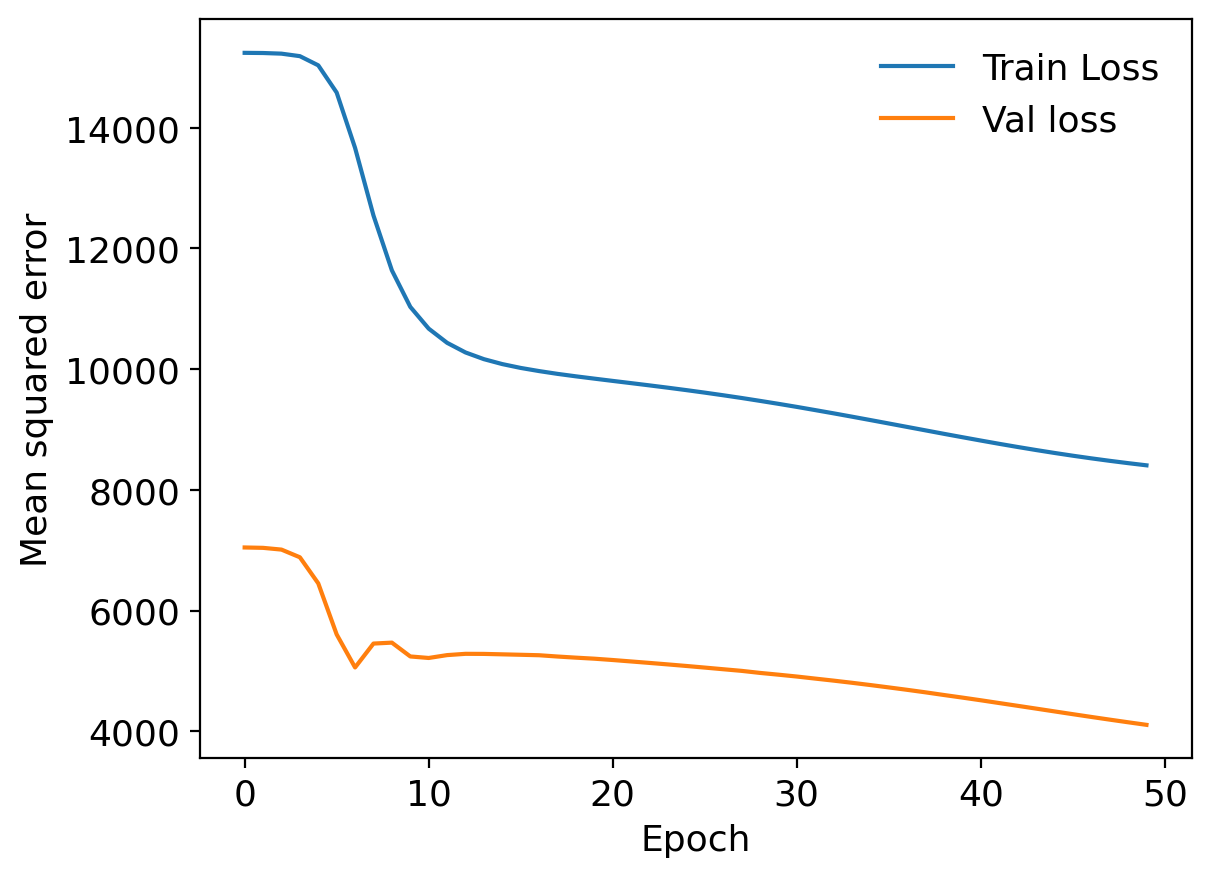

In [55]:
plot_history(history)

In [56]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [57]:
lstm_model.save(os.path.join(model_path,'LSTM_model_1_member.h5'))

## Testing

In [58]:
model = load_model(os.path.join(model_path,'LSTM_model_1_member.h5'))

In [59]:
y_test_df = pd.DataFrame(output_test.velsurf_mag.stack(dim=["y", "x"]).to_pandas()).fillna(0)

In [60]:
y_test = y_test_df.to_numpy()

In [61]:
y_test_pre = model.predict(X_test)


7/7 [==============================] - 0s 2ms/step


In [62]:
y_test_pre_rs = y_test_pre.reshape(y_test_pre.shape[0],y_test_df.columns.levels[1].shape[0],y_test_df.columns.levels[0].shape[0])

y_test_pre_xr = xr.Dataset(coords={'time': input_test.time.values[slider-1:], 
                               'x': y_test_df.columns.levels[1].values, 
                               'y': y_test_df.columns.levels[0].values},
                       data_vars=dict(velsurf_mag=(['time', 'y', 'x'], y_test_pre_rs)))

In [63]:
y_test_pre_xr

<xarray.Dataset>
Dimensions:      (time: 200, y: 381, x: 381)
Coordinates:
  * time         (time) float64 -1.98e+04 -1.97e+04 -1.96e+04 ... 0.0 50.0
  * x            (x) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
  * y            (y) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
Data variables:
    velsurf_mag  (time, y, x) float32 0.002926 0.002063 ... -0.001066 0.004216

In [64]:
y_true =  y_test_df.unstack().to_xarray()

In [65]:
y_true

<xarray.DataArray (y: 381, x: 381, time: 200)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * y        (y) float64 -3.04e+06 -3.024e+06 -3.008e+06 ... 3.024e+06 3.04e+06
  * x        (x) float64 -3.04e+06 -3.024e+06 -3.008e+06 ... 3.024e+06 3.04e+06
  * time     (time) float64 -1.98e+04 -1.97e+04 -1.96e+04 ... -100.0 0.0 50.0

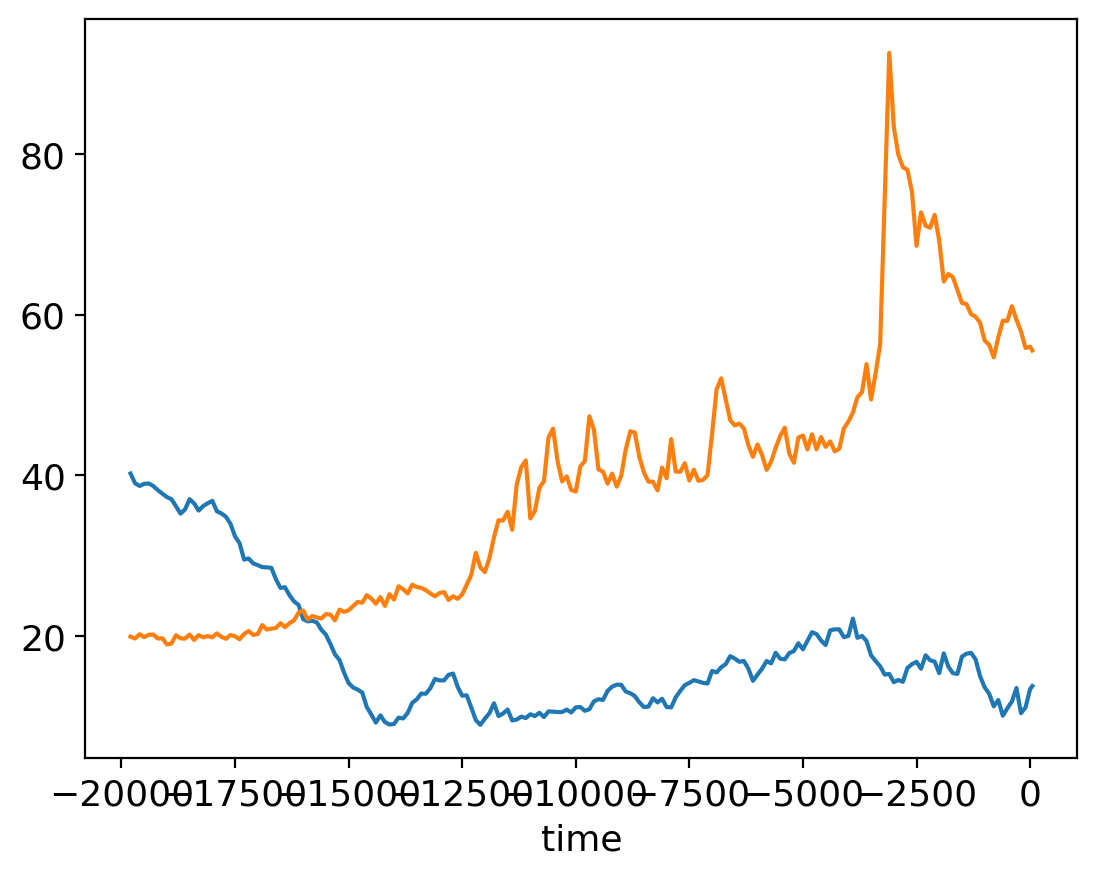

In [66]:
y_test_pre_xr.velsurf_mag.mean(dim=['x','y']).plot()
y_true.mean(dim=['x','y']).plot()

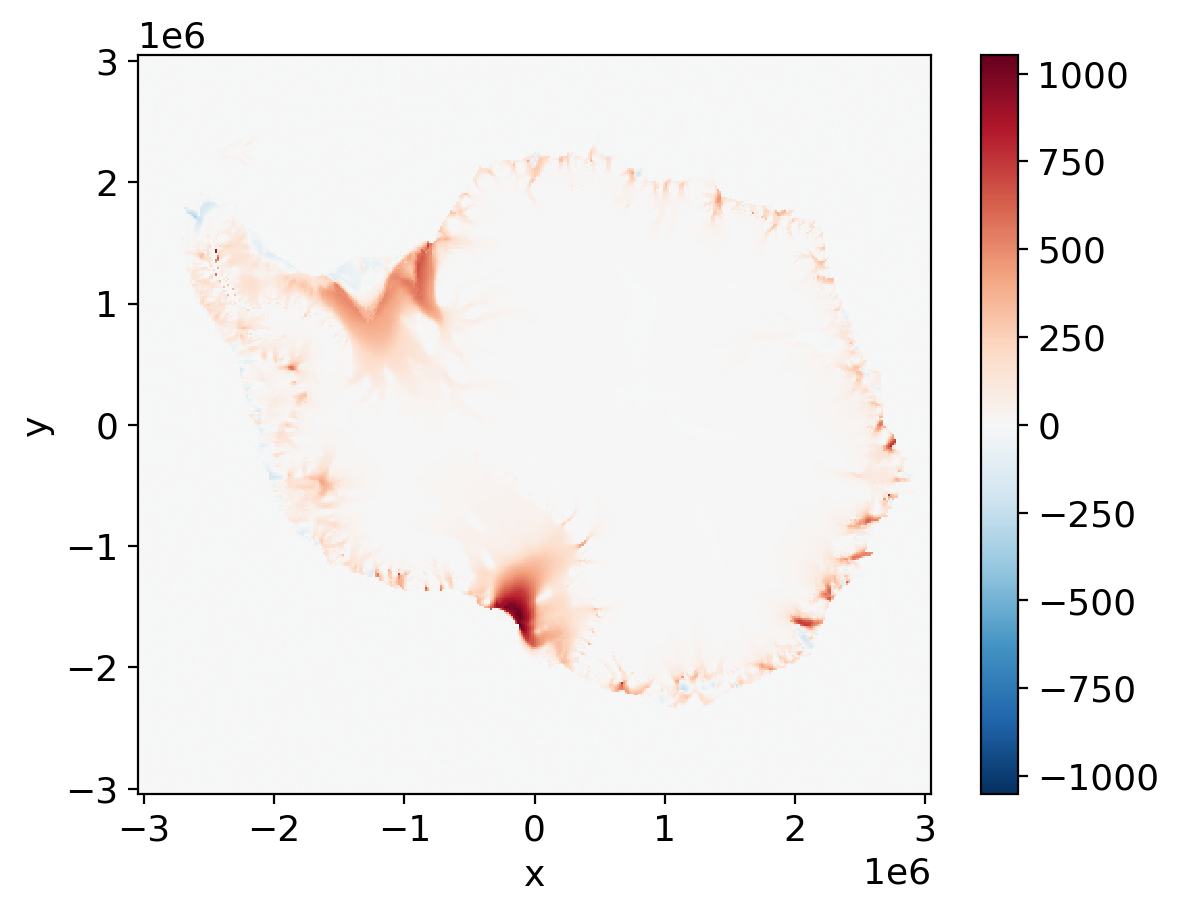

In [67]:
(y_true-y_test_pre_xr.velsurf_mag).mean(dim='time').plot()

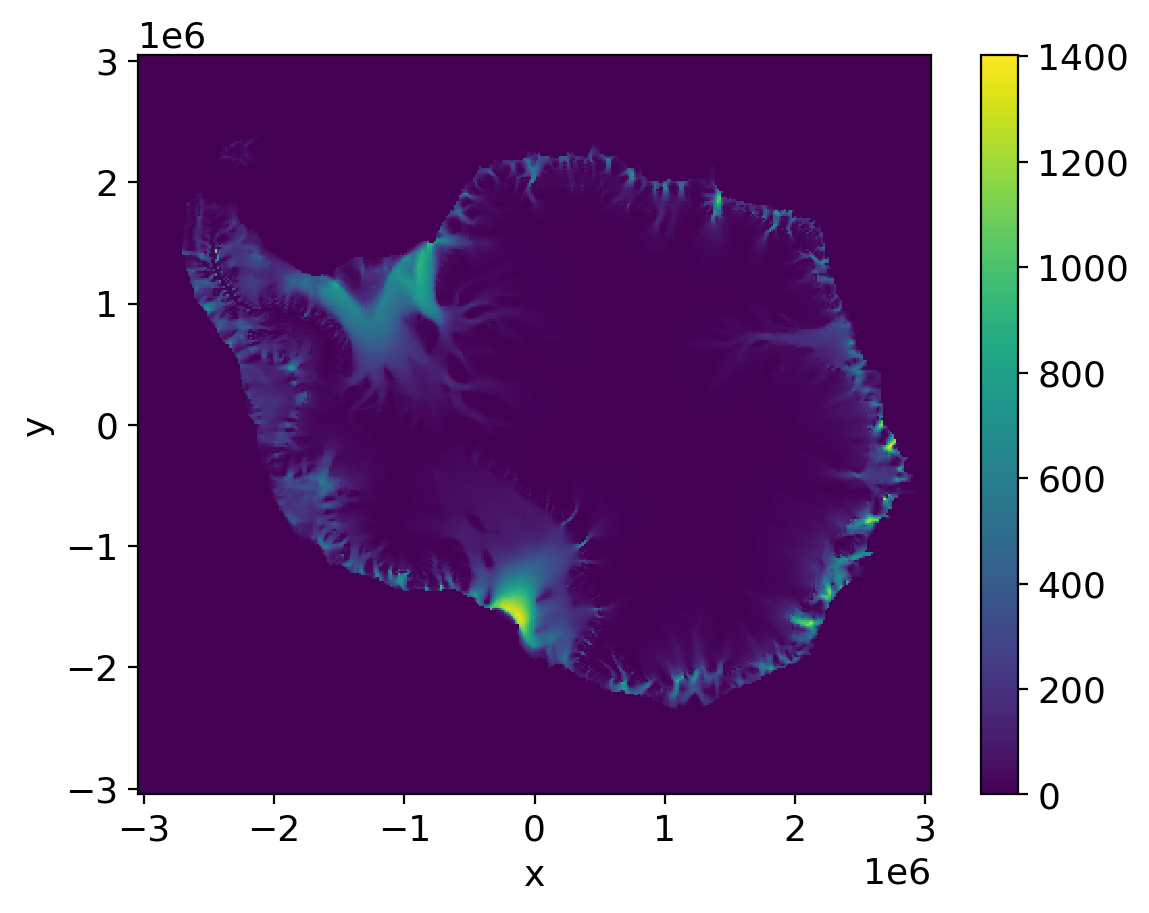

In [68]:
y_true.mean(dim='time').plot()

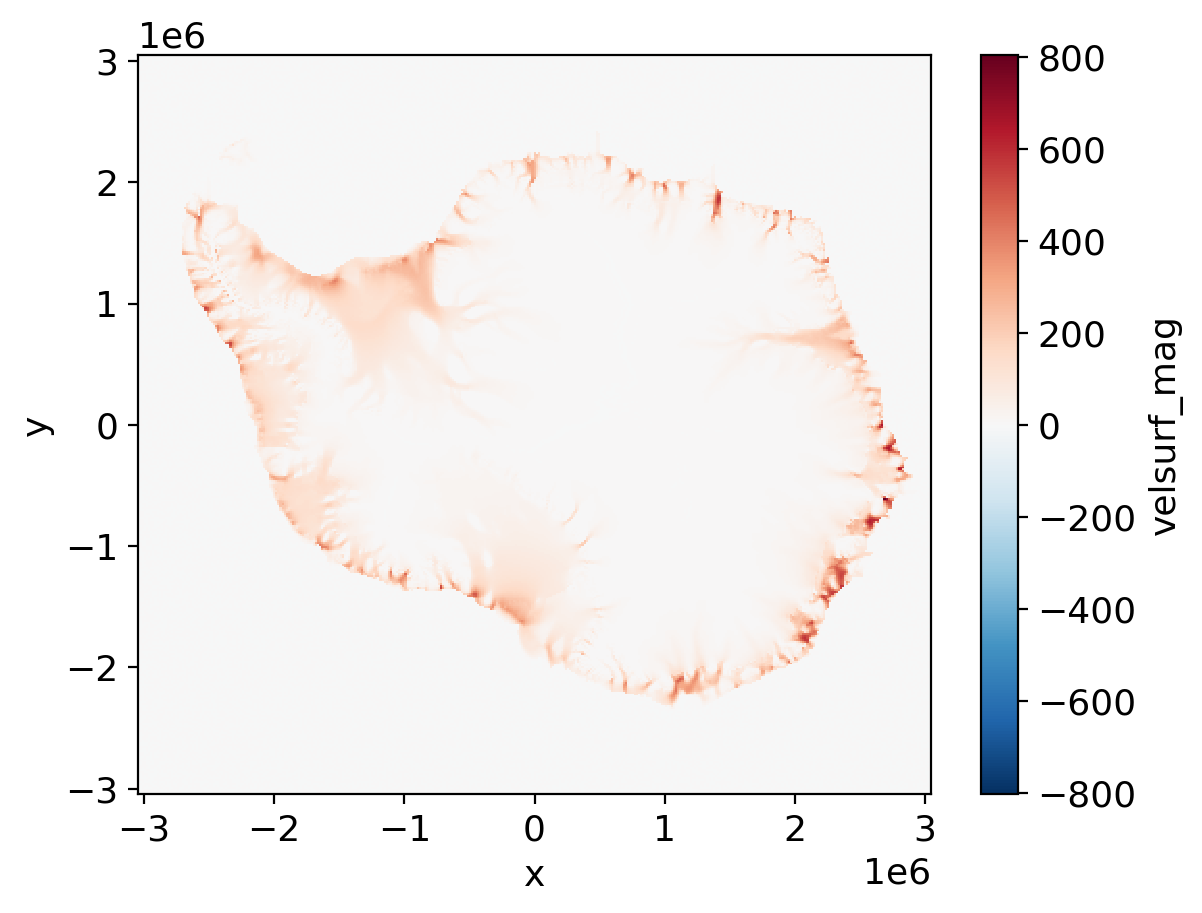

In [69]:
y_test_pre_xr.velsurf_mag.mean(dim='time').plot()